In [1]:
!git clone 'https://github.com/aakashvardhan/custom-lit-yolov3.git'
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/kaggle/working/custom-lit-yolov3')
sys.path.append('/kaggle/input/pascal-voc/PASCAL_VOC')
!pip install -r /kaggle/working/custom-lit-yolov3/requirements.txt

Cloning into 'custom-lit-yolov3'...
remote: Enumerating objects: 217, done.
remote: Counting objects: 100% (217/217), done.
remote: Compressing objects: 100% (152/152), done.
remote: Total 217 (delta 83), reused 174 (delta 40), pack-reused 0
Receiving objects: 100% (217/217), 2.45 MiB | 13.96 MiB/s, done.
Resolving deltas: 100% (83/83), done.
  Obtaining dependency information for lightning from https://files.pythonhosted.org/packages/9e/8a/9642fdbdac8de47d68464ca3be32baca3f70a432aa374705d6b91da732eb/lightning-2.1.2-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 28.1 MB/s eta 0:00:00


In [2]:
import torch
from lit_model import YOLOv3LightningModule
from lit_data_module import YOLODataModule
from pytorch_lightning import Trainer
import lightning as pl
from lightning.pytorch.callbacks import ModelCheckpoint, LearningRateMonitor, RichModelSummary,EarlyStopping
import torch
import os
import config as cfg

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
cfg.DATASET = '/kaggle/input/pascal-voc-dataset-used-in-yolov3-video/PASCAL_VOC'
cfg.IMG_DIR = cfg.DATASET + "/images/"
cfg.LABEL_DIR = cfg.DATASET + "/labels/"

In [4]:
torch.cuda.empty_cache()
pl.seed_everything(1, workers=True)

INFO: Seed set to 1


1

In [5]:
train_dir = '/kaggle/input/pascal-voc-dataset-used-in-yolov3-video/PASCAL_VOC/train.csv'
test_dir = '/kaggle/input/pascal-voc-dataset-used-in-yolov3-video/PASCAL_VOC/test.csv'
datamodule = YOLODataModule(config=cfg, train_dir=train_dir, test_dir=test_dir)
datamodule.setup()

In [6]:
model = YOLOv3LightningModule(config=cfg)

In [7]:
from callbacks import ClassAccuracyCallback, PlotExampleCallback, MAPCallback
from pytorch_lightning.loggers import TensorBoardLogger

In [8]:
EPOCHS = int(cfg.NUM_EPOCHS * 0.4)

In [9]:
# Tensorboard logger
tb_logger = TensorBoardLogger(save_dir="logs/", name="model")
# Initialize the Lightning Trainer

In [10]:
trainer = pl.Trainer(precision="16-mixed", max_epochs=EPOCHS,
                     logger= tb_logger,
                              callbacks=[ModelCheckpoint(dirpath="checkpoints/",verbose=True,),
                              ClassAccuracyCallback(config=cfg,train_n_epochs=1, test_n_epochs=10),
                              PlotExampleCallback(config=cfg, n_epochs = EPOCHS),
                              MAPCallback(config=cfg, test_n_epochs = EPOCHS),
                              RichModelSummary(max_depth=-1),
                              LearningRateMonitor()])

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/40 [00:00<?, ?it/s]

INFO: LR finder stopped early after 31 steps due to diverging loss.
INFO: Learning rate set to 0.005011872336272723


new_lr=0.005011872336272723


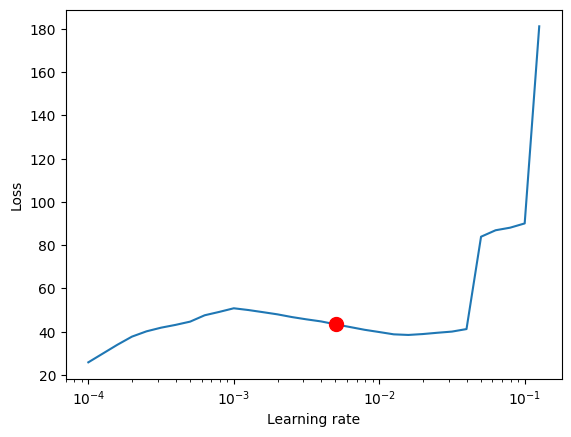

In [11]:
from lightning.pytorch.tuner import Tuner

# Create a Tuner
tuner = Tuner(trainer)

# Finding the learning rate
lr_finder =tuner.lr_find(model,datamodule=datamodule, min_lr=1e-4, max_lr=1, num_training=trainer.max_epochs)

# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()
# Pick point based on plot, or get suggestion
new_lr = lr_finder.suggestion()
print(f"{new_lr=}")

In [12]:
cfg.DATASET

'/kaggle/input/pascal-voc-dataset-used-in-yolov3-video/PASCAL_VOC'